# <center> Current Research in Data Science
# <center> Interpretable Machine Learning: Bank Campaign 
## <center> Hypothesis 1 & 5 

**Task 1**:

 What are the most important features and how much do they contribute to the success rate?

**Task 5**:

How can the bank managers strategise campaign features to get maximum success?


**To Do**:

1. Adapt Shapley value, SHAP feat imp, SHAP summary plot
2. Adapt SHAP individual prediction, Clustering SHAP values, Global Surrogate
3. Adapt SHAP dependency plot, SHAP interaction value

# Load Data and Model

In [1]:
%load_ext autoreload

import sys
sys.path.insert(0, "../src")

import os
os.chdir("../src")

import pickle
import csv
import joblib
import pandas as pd
from data_generator import DataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

In [2]:
dataGenerator = DataGenerator('../data/imputed_bank_data_mice.csv', True, False);
# dataGenerator = DataGenerator('../data/bank-additional-full.csv', False, False);
x_train, x_test, y_train, y_test  = dataGenerator.load_data();


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [3]:
with open('../results/Models/LGBM/model.pkl', 'rb') as file:
    lgbm = joblib.load(file)

### ***Interpretable Machine Learning Libraries***

In [4]:
# !pip install shap
import sklearn
import shap
# print the JS visualization code to the notebook
shap.initjs()

# Get shaply values

In [5]:
file_path0 = '../results/Models/LGBM/shap_values.pkl'
file_path1 = '../results/Models/LGBM/shap_interaction_values.pkl'

In [6]:
try:
    print(explainer) # does a exist in the current namespace
    print('Explainer exist')
except NameError:
    print('Creating explainer')
    explainer = shap.TreeExplainer(lgbm)

Creating explainer


In [7]:
try:
    print(explainer2) # does a exist in the current namespace
    print('Explainer2  for waterfall exist')
except NameError:
    print('Creating explainer2 for waterfall')
    explainer2 = shap.TreeExplainer(lgbm, x_train)
    explaination = explainer2(x_test)
explaination.shape

Creating explainer2 for waterfall


100%|===================| 8125/8153 [00:28<00:00]        

(8153, 55)

In [8]:
if os.path.exists(file_path0):
    print('Shap Values already exist')
    with open(file_path0, 'rb') as f:
         shap_values = pickle.load(f)
else:
    print('Calculating Shap Values values')
    shap_values = explainer.shap_values(x_test)
    with open(file_path0, "wb") as f:
        pickle.dump(shap_values, f)
        
print(len(shap_values), shap_values[0].shape)

Shap Values already exist
2 (8153, 55)


In [9]:
if os.path.exists(file_path1):
    print('Interaction Values already exist')
    with open(file_path1, 'rb') as f:
         shap_interaction_values = pickle.load(f)
else:
    print('Calculating Interaction values')
    shap_interaction_values = explainer.shap_interaction_values(x_test)
    with open(file_path1, "wb") as f:
        pickle.dump(shap_interaction_values, f)

shap_interaction_values.shape

Interaction Values already exist


(8153, 55, 55)

## Reverse transform numerical values

In [10]:
x_test = dataGenerator.rev_transform(x_test, rev_num_features=True, rev_cat_features=False)

# Handle One Hot Encoding

In [11]:
# Handle SHAP Values
# Specify num and cat features
num_features = ["age", "campaign", "previous", "emp.var.rate", "cons.price.idx", 
                "cons.conf.idx", "euribor3m", "nr.employed"]
cat_features = list(set(list(x_test)) - set(num_features))
# Get index of each feature in dataset
index_dict = {}
for column in list(x_test):
    key = column.split('_')[0]
    if key in index_dict:
        index_dict[key].append(list(x_test).index(column))
    else:
        index_dict[key] = [list(x_test).index(column)]
# Create cat index
cat_index_list = []
for column in cat_features:
    key = column.split('_')[0]
    cat_index_list.append(key)
cat_index_list = set(cat_index_list)
# Create new shap values
individual_shap_dict = {}
feature = {}
new_shape_values = []
for i in range(2):
    shap_temp = shap_values[i]
    for key, value in index_dict.items():
        individual_shap_dict[key] = shap_temp[:,value].sum(axis=1)
        feature[key] = x_test[[x_test.columns[i] for i in value]]
    new_shape_values.append(np.array(list(individual_shap_dict.values())).transpose())
# Convert one hot encoding back
for key in feature.keys():
    if key in cat_index_list:
        feature[key] = feature[key].idxmax(axis=1)
for key in feature.keys():
    if not key in cat_index_list:
        feature[key] = feature[key][key]
# Create datafame        
feature = pd.DataFrame.from_dict(feature)
feature = feature.rename(columns={"binned": "duration"})
new_shape_values = np.array(new_shape_values)


# Handle interaction values
first = {}
second = {}
new_interaction_values = []
for key, value in index_dict.items():
    first[key] = shap_interaction_values[:,:, value].sum(axis=2)
new_interaction_values.append(np.array(list(first.values())).transpose(1,0,2))
first = np.array(new_interaction_values).squeeze()

new_interaction_values = []
for key, value in index_dict.items():
    second[key] = first[:,:,value].sum(axis=2)

new_interaction_values.append(np.array(list(second.values())).transpose(1,2,0))
new_interaction_values = np.array(new_interaction_values).squeeze()

new_shape_values.shape, new_interaction_values.shape

((2, 8153, 18), (8153, 18, 18))

## Feture importance

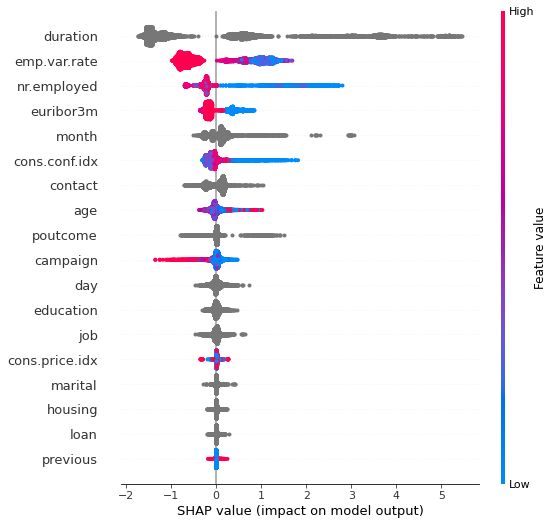

In [12]:
shap.summary_plot(new_shape_values[1], feature, plot_type="dot",max_display =18)

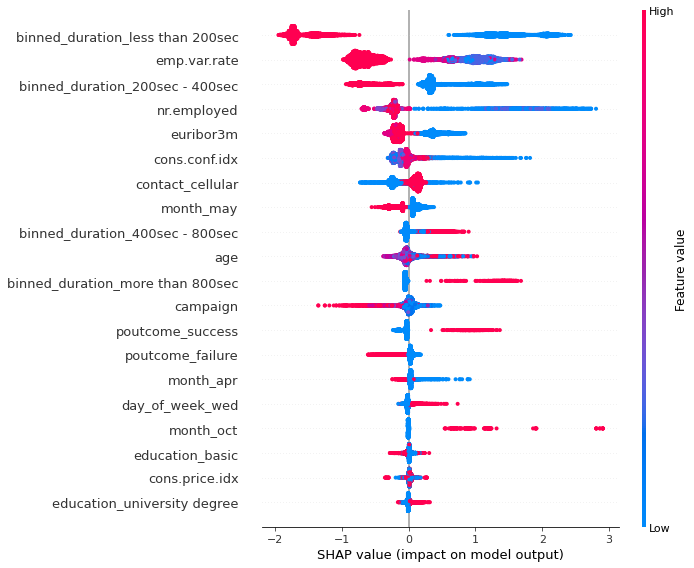

In [13]:
# Top 20
shap.summary_plot(shap_values[1], x_test, max_display =20)

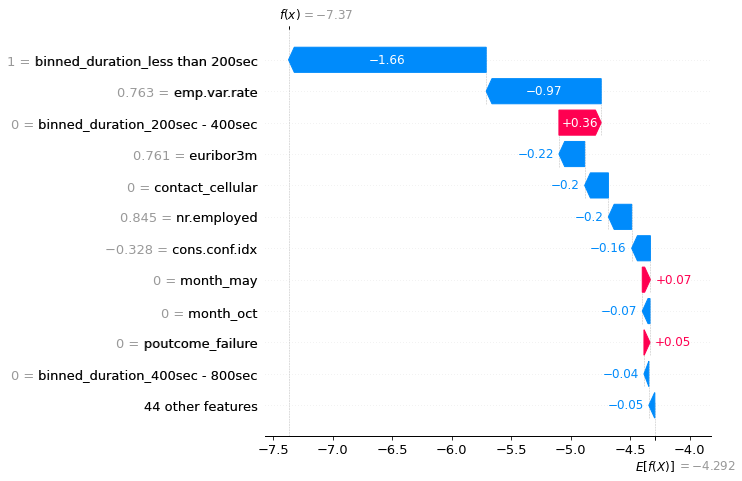

In [14]:
# Unsuccesful campaign
shap.plots.waterfall(explaination[2], max_display=12)

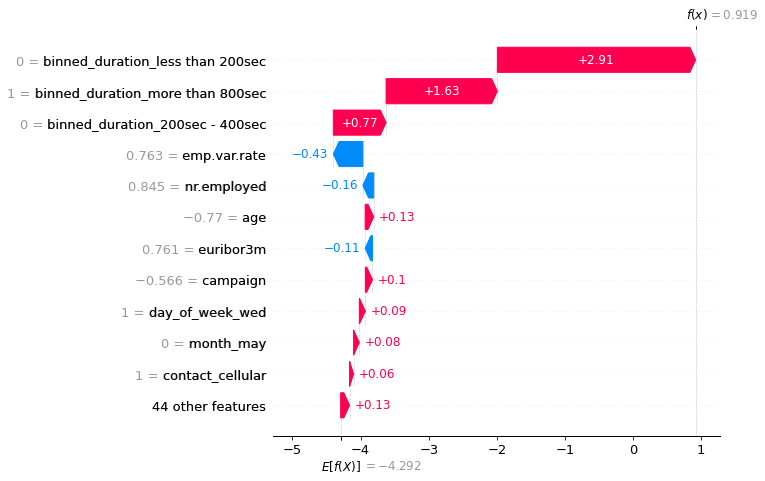

In [15]:
# Successful Campaign
shap.plots.waterfall(explaination[6], max_display=12)

### Interactions

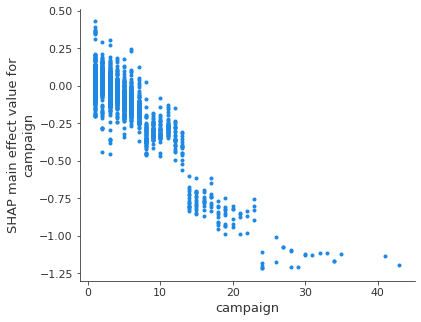

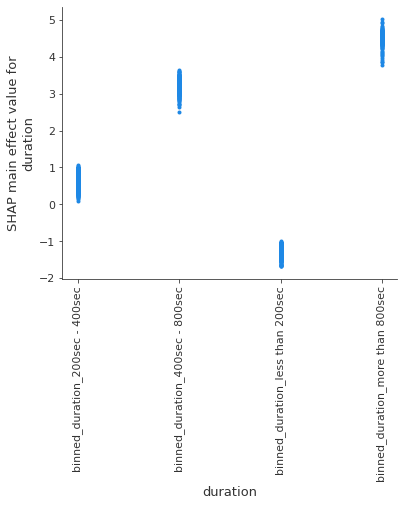

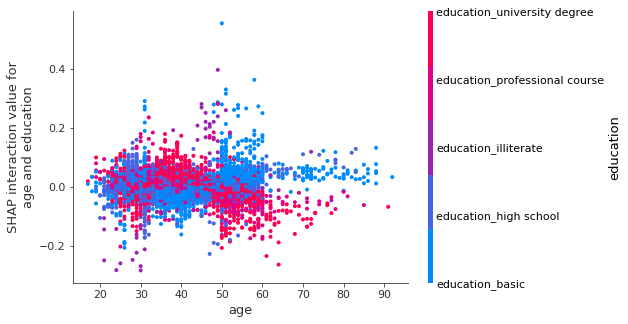

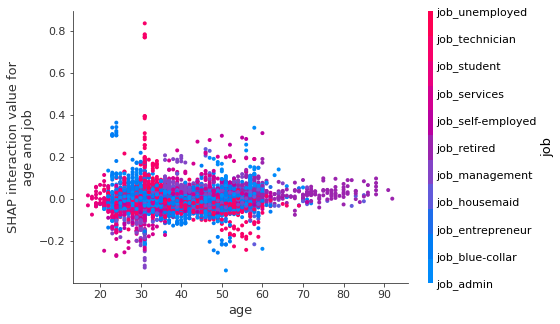

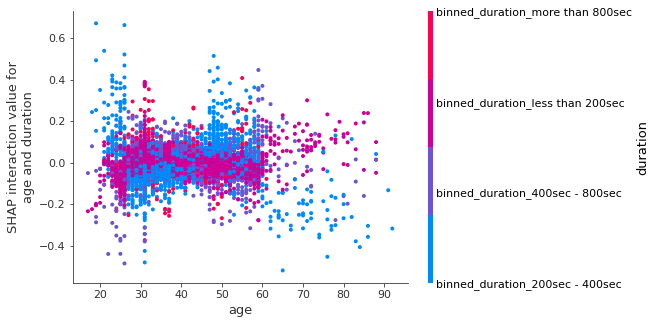

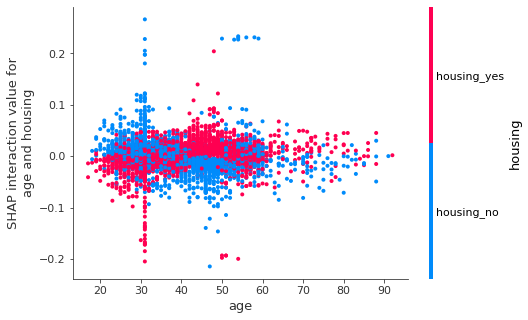

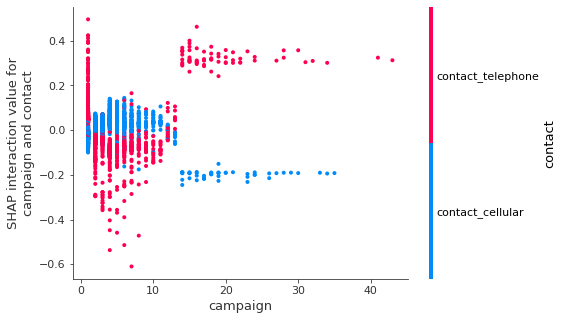

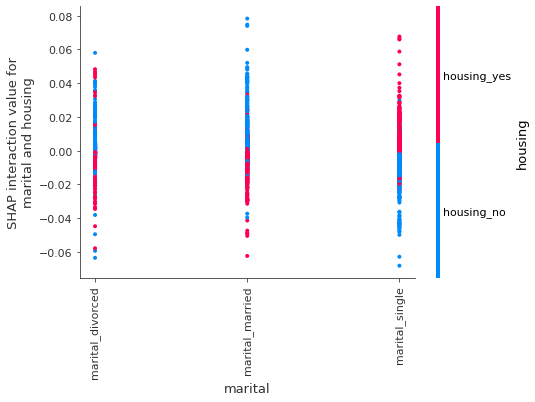

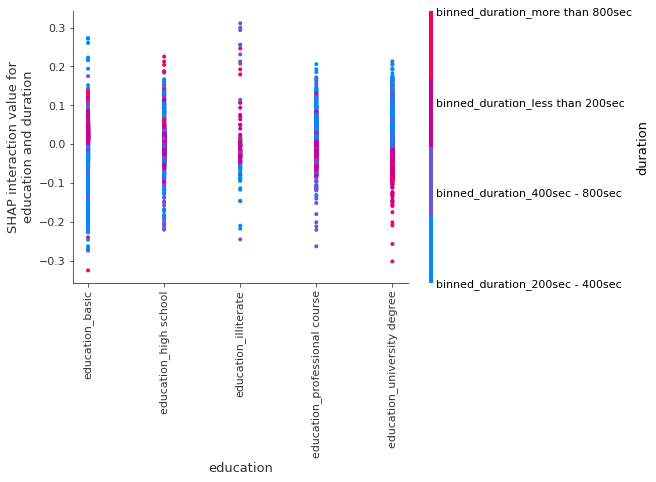

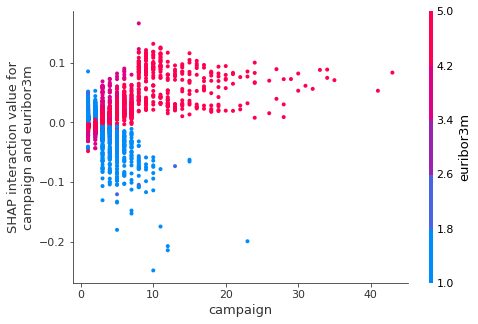

In [16]:
dependencies = [
    ("campaign", "campaign"),
    ("duration", "duration"),
    ("age", "education"),
    ("age", "job"),
    ("age", "duration"),
    ("age", "housing"),
    ("campaign", "contact"),
    ("marital", "housing"),
    ("education", "duration"),
    ("campaign", "euribor3m"),
]

for case in dependencies:
    shap.dependence_plot(
        case,
        new_interaction_values, feature,
        display_features=feature,
    );